In [3]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

from sklearn.preprocessing import StandardScaler

import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)



cuda


In [28]:
##
## Parameters
##

# time step
dt=0.025
# units of time to warm up NVAR. need to have warmup_pts >= 1
warmup = 5.
# units of time to train for
traintime = 10.
# units of time to test for
testtime=20.
# total time to run for
maxtime = warmup+traintime+testtime
# how much of testtime to plot
plottime=20.
# Lyapunov time of the Lorenz system
lyaptime=1.104

# discrete-time versions of the times defined above
warmup_pts=round(warmup/dt)
traintime_pts=round(traintime/dt)
warmtrain_pts=warmup_pts+traintime_pts
testtime_pts=round(testtime/dt)
maxtime_pts=round(maxtime/dt)
plottime_pts=round(plottime/dt)
lyaptime_pts=round(lyaptime/dt)

# input dimension
d = 3
# number of time delay taps
k = 2
# size of linear part of feature vector
dlin = k*d
# size of nonlinear part of feature vector
dnonlin = int(dlin*(dlin+1)/2)
# total size of feature vector: constant + linear + nonlinear
dtot = 1 + dlin + dnonlin

# ridge parameter for regression
ridge_param = 2.5e-6

# t values for whole evaluation time
# (need maxtime_pts + 1 to ensure a step of dt)
t_eval=np.linspace(0,maxtime,maxtime_pts+1)

In [29]:
##
## Lorenz '63
##

sigma = 10
beta = 8 / 3
rho = 28

def lorenz(t, y):

  dy0 = sigma * (y[1] - y[0])
  dy1 = y[0] * (rho - y[2]) - y[1]
  dy2 = y[0] * y[1] - beta * y[2]

  # since lorenz is 3-dimensional, dy/dt should be an array of 3 values
  return [dy0, dy1, dy2]


In [30]:

# I integrated out to t=50 to find points on the attractor, then use these as the initial conditions

lorenz_soln = solve_ivp(lorenz, (0, maxtime), [17.67715816276679, 12.931379185960404, 43.91404334248268] , t_eval=t_eval, method='RK23')

# total variance of Lorenz solution
total_var=np.var(lorenz_soln.y[0:d,:])

[[17.67715816 15.77695495 12.83202575  9.49915688  6.31667148]
 [12.93137919  5.68211629 -0.14898817 -3.81814923 -5.64699747]
 [43.91404334 44.85194679 42.87695699 39.54693535 36.08397169]
 [ 0.         17.67715816 15.77695495 12.83202575  9.49915688]
 [ 0.         12.93137919  5.68211629 -0.14898817 -3.81814923]
 [ 0.         43.91404334 44.85194679 42.87695699 39.54693535]]


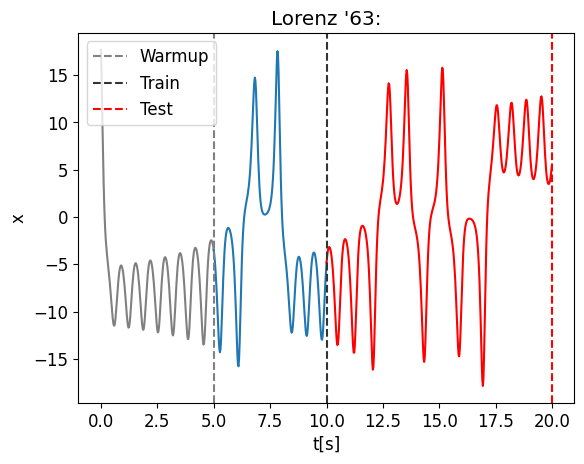

In [31]:
# create an array to hold the linear part of the feature vector
x = np.zeros((dlin,maxtime_pts))

# fill in the linear part of the feature vector for all times
for delay in range(k):
    for j in range(delay,maxtime_pts):
        x[d*delay:d*(delay+1),j]=lorenz_soln.y[:,j-delay]

#scaler = StandardScaler()
#x = scaler.fit_transform(x)


print(x[:,0:5])
plt.plot(t_eval[0:warmup_pts+1],x[0,0:warmup_pts+1],"0.5")
plt.plot(t_eval[warmup_pts:traintime_pts+1],x[0,warmup_pts:traintime_pts+1])
plt.plot(t_eval[traintime_pts:testtime_pts],x[0,traintime_pts:testtime_pts], "r")
plt.axvline(x=warmup_pts*dt, ls='--', color='0.5', label='Warmup')
plt.axvline(x=traintime_pts*dt, ls='--', color='0.2', label='Train')
plt.axvline(x=testtime_pts*dt, ls='--', color='r', label='Test')
plt.legend(loc='upper left')

plt.title("Lorenz '63:")
plt.xlabel("t[s]")
plt.ylabel("x")
plt.show()



In [89]:
input_size = dlin
sequence_length = 2

num_layers=2
hidden_size=512

learning_rate = 0.0001

output_dim = 3
batch_size = 1

In [90]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, output_dim, sequence_length):
    super(RNN, self).__init__()
    self.num_layers = num_layers
    self.hidden_size = hidden_size

    self.rnn = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_dim)
    # x -> batch size, seq, input

  def forward(self, x):
#      h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
      h0 = torch.zeros(self.num_layers, self.hidden_size).to(device)

      out, _ = self.rnn(x, h0)
      #out = out[:,-1,:]
      out = self.fc(out)
      return out


In [91]:
"""
class SimpleGRU(nn.Module):
    def __init__(self, input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes, sequence_length=sequence_length):
        super(SimpleGRU, self).__init__()
        self.hidden_size  = hidden_size
        self.num_layers = num_layers

        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        #self.fc1 = nn.Linear(hidden_size * sequence_length, num_classes)

    def forward(self, inp, hidden_state):
        #h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        #out,_ = self.gru(x, h0)
        #out = out.reshape(out.shape[0], -1)
        #out = self.fc1(out)
        return self.gru(inp, hidden_state)#out

model = SimpleGRU().to(device=device)
"""

'\nclass SimpleGRU(nn.Module):\n    def __init__(self, input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes, sequence_length=sequence_length):\n        super(SimpleGRU, self).__init__()\n        self.hidden_size  = hidden_size\n        self.num_layers = num_layers\n\n        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)\n        #self.fc1 = nn.Linear(hidden_size * sequence_length, num_classes)\n\n    def forward(self, inp, hidden_state):\n        #h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)\n\n        #out,_ = self.gru(x, h0)\n        #out = out.reshape(out.shape[0], -1)\n        #out = self.fc1(out)\n        return self.gru(inp, hidden_state)#out\n\nmodel = SimpleGRU().to(device=device)\n'

In [92]:
model = RNN(input_size, hidden_size, num_layers, output_dim, sequence_length).to(device)

x_tensor = torch.tensor(x, dtype=torch.float32)#.reshape(-1, sequence_length, input_size)
x_tensor.to(device)
loss_criterion  = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

#x_tensor = x_tensor.reshape(-1,input_size, sequence_length)
x_tensor.shape
#print(x_tensor[0:3,:,:])
#x_out = torch.zeros(x_tensor.shape).reshape(3,-1)
#x_out.shape

torch.Size([6, 1400])

At epoch: 0, loss: 1.838640404206235
At epoch: 10, loss: 0.14802515349510942
At epoch: 20, loss: 0.07345554174742575
At epoch: 30, loss: 0.0901171930788405
At epoch: 40, loss: 0.1590502440761702
At epoch: 50, loss: 0.05193494534174534
At epoch: 60, loss: 0.044314632403875294
At epoch: 70, loss: 0.03163276601642792
At epoch: 80, loss: 0.05351370963747286
At epoch: 90, loss: 0.03315382474344006
At epoch: 100, loss: 0.03170278255211088
At epoch: 110, loss: 0.030244384666330008
At epoch: 120, loss: 0.019770312864939115
At epoch: 130, loss: 0.01091163685943684
At epoch: 140, loss: 0.02433094167472518
At epoch: 150, loss: 0.020412147798474507
At epoch: 160, loss: 0.014066558394159757
At epoch: 170, loss: 0.017716965774015988
At epoch: 180, loss: 0.01286380745961651
At epoch: 190, loss: 0.016454948085520726
At epoch: 200, loss: 0.009935945712172725
At epoch: 210, loss: 0.013010208546952527
At epoch: 220, loss: 0.015727671214372095
At epoch: 230, loss: 0.010323576716564276
At epoch: 240, loss:

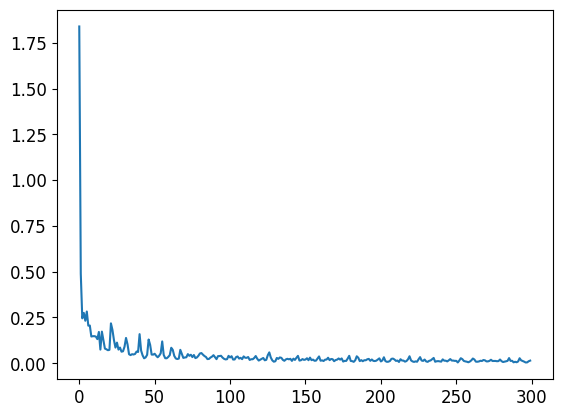

In [93]:
current_loss = 0
num_epochs = 300
loss_hist = []
loss = 0
model.train()

for epoch in range(num_epochs):
    for i in range(traintime_pts - 1):
        index = i + warmup_pts -1
        target = x_tensor[0:d,index+sequence_length]-x_tensor[d:dlin,index+sequence_length]
        data = x_tensor[:,index:index+sequence_length]
        data = data.to(device)
        data = torch.transpose(data, 0, 1)
        target = target.to(device)
        outputs = model(data)
        loss = loss_criterion(outputs[sequence_length-1,:],target)
        current_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if (epoch % 10 == 0):
        print(f"At epoch: {epoch}, loss: {current_loss/traintime_pts}")
    loss_hist.append(current_loss/traintime_pts)
    current_loss = 0

plt.plot(loss_hist)
plt.show()

# calculate NRMSE between true Lorenz and training output
#rms = np.sqrt(np.mean((x[0:d,warmup_pts:warmtrain_pts]-x_predict[:,:])**2)/total_var)
#print('training nrmse: '+str(rms))

In [1]:

def evaluate():
    model.eval()
    total_acc, total_count = 0, 0
    predicted = torch.zeros(dlin,testtime_pts).to(device)
    predicted[:,0:sequence_length+1] = x_tensor[:,warmtrain_pts:warmtrain_pts+sequence_length+1]
    with torch.no_grad():
        for i in range(testtime_pts-sequence_length-1):
          xin = predicted[:,i:i+sequence_length]
          output = model(torch.transpose(xin, 0, 1))
          predicted[d:dlin,i+sequence_length+1] = predicted[0:d,i+sequence_length]
          predicted[0:d,i+sequence_length+1] = output[sequence_length-1,:] + predicted[d:dlin,i+sequence_length+1]
          #loss = loss_criterion(predicted[:,i], x_tensor[:,testtime_pts+i])
          total_acc += loss
          #total_count += label.size(0)
    return predicted

xin = torch.zeros(dlin,sequence_length).to(device)
pred = evaluate()

MSE = loss_criterion(x_tensor[0:d,warmtrain_pts-1:warmtrain_pts+lyaptime_pts-1].cpu(), pred[0:d,0:lyaptime_pts].cpu())

print(MSE)

#MSE = loss_criterion(x_tensor[0:d,warmtrain_pts-1:warmtrain_pts+lyaptime_pts-1].cpu(), torch.tensor(x_test[0:d,0:lyaptime_pts]))

print(MSE)

# calculate MSE between true Lorenz and prediction for one Lyapunov time
#test_nrmse = np.sqrt(np.mean((x_tensor[0:d,warmtrain_pts-1:warmtrain_pts+lyaptime_pts-1].cpu().detach().numpy()-pred[0:d,0:lyaptime_pts].cpu().detach().numpy()**2)/total_var))
#print('test nrmse: '+str(test_nrmse))

NameError: name 'torch' is not defined

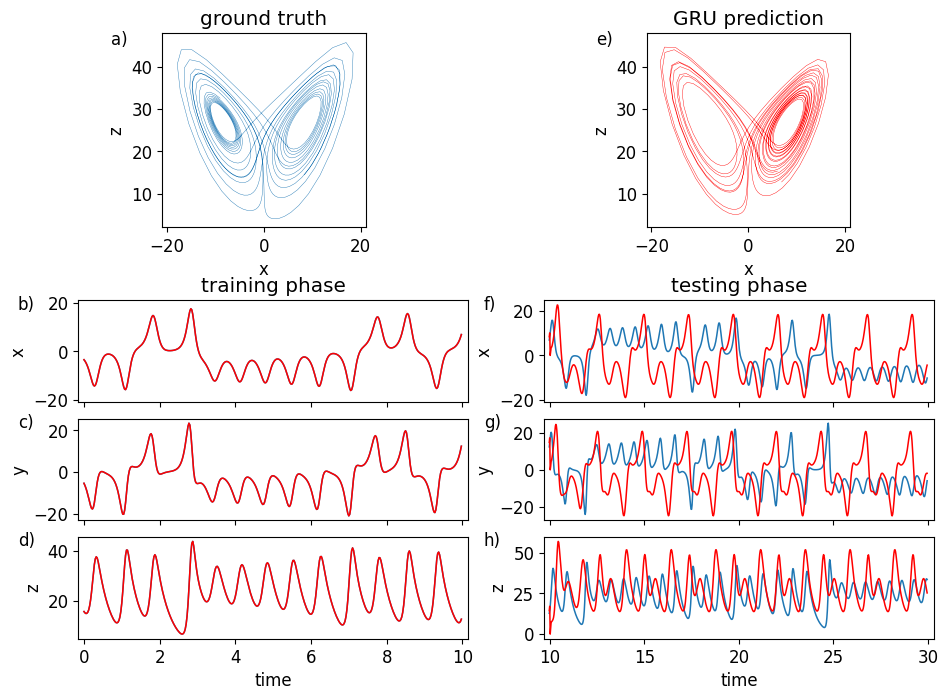

In [97]:

##
## Plot
##



t_linewidth=1.1
a_linewidth=0.3
plt.rcParams.update({'font.size': 12})

fig1 = plt.figure()
fig1.set_figheight(8)
fig1.set_figwidth(12)

xlabel=[10,15,20,25,30]
h=120
w=100

# top left of grid is 0,0
axs1 = plt.subplot2grid(shape=(h,w), loc=(0, 9), colspan=22, rowspan=38)
axs2 = plt.subplot2grid(shape=(h,w), loc=(52, 0), colspan=42, rowspan=20)
axs3 = plt.subplot2grid(shape=(h,w), loc=(75, 0), colspan=42, rowspan=20)
axs4 = plt.subplot2grid(shape=(h,w), loc=(98, 0), colspan=42, rowspan=20)
axs5 = plt.subplot2grid(shape=(h,w), loc=(0, 61), colspan=22, rowspan=38)
axs6 = plt.subplot2grid(shape=(h,w), loc=(52, 50),colspan=42, rowspan=20)
axs7 = plt.subplot2grid(shape=(h,w), loc=(75, 50), colspan=42, rowspan=20)
axs8 = plt.subplot2grid(shape=(h,w), loc=(98, 50), colspan=42, rowspan=20)

# true Lorenz attractor
axs1.plot(x[0,warmtrain_pts:maxtime_pts],x[2,warmtrain_pts:maxtime_pts],linewidth=a_linewidth)
axs1.set_xlabel('x')
axs1.set_ylabel('z')
axs1.set_title('ground truth')
axs1.text(-.25,.92,'a)', ha='left', va='bottom',transform=axs1.transAxes)
axs1.axes.set_xbound(-21,21)
axs1.axes.set_ybound(2,48)

# training phase x
axs2.set_title('training phase')
axs2.plot(t_eval[warmup_pts:warmtrain_pts]-warmup,x[0,warmup_pts:warmtrain_pts],linewidth=t_linewidth)
axs2.plot(t_eval[warmup_pts:warmtrain_pts]-warmup,x_predict[0,:],linewidth=t_linewidth, color='r')
axs2.set_ylabel('x')
axs2.text(-.155,0.87,'b)', ha='left', va='bottom',transform=axs2.transAxes)
axs2.axes.xaxis.set_ticklabels([])
axs2.axes.set_ybound(-21.,21.)
axs2.axes.set_xbound(-.15,10.15)

# training phase y
axs3.plot(t_eval[warmup_pts:warmtrain_pts]-warmup,x[1,warmup_pts:warmtrain_pts],linewidth=t_linewidth)
axs3.plot(t_eval[warmup_pts:warmtrain_pts]-warmup,x_predict[1,:],linewidth=t_linewidth,color='r')
axs3.set_ylabel('y')
axs3.text(-.155,0.87,'c)', ha='left', va='bottom',transform=axs3.transAxes)
axs3.axes.xaxis.set_ticklabels([])
axs3.axes.set_xbound(-.15,10.15)

# training phase z
axs4.plot(t_eval[warmup_pts:warmtrain_pts]-warmup,x[2,warmup_pts:warmtrain_pts],linewidth=t_linewidth)
axs4.plot(t_eval[warmup_pts:warmtrain_pts]-warmup,x_predict[2,:],linewidth=t_linewidth,color='r')
axs4.set_ylabel('z')
axs4.text(-.155,0.87,'d)', ha='left', va='bottom',transform=axs4.transAxes)
axs4.set_xlabel('time')
axs4.axes.set_xbound(-.15,10.15)

# prediction attractor
axs5.plot(x_test[0,:],x_test[2,:],linewidth=a_linewidth,color='r')
axs5.set_xlabel('x')
axs5.set_ylabel('z')
axs5.set_title('GRU prediction')
axs5.text(-.25,0.92,'e)', ha='left', va='bottom',transform=axs5.transAxes)
axs5.axes.set_xbound(-21,21)
axs5.axes.set_ybound(2,48)

# testing phase x
axs6.set_title('testing phase')
axs6.set_xticks(xlabel)
axs6.plot(t_eval[warmtrain_pts-1:warmtrain_pts+plottime_pts-1]-warmup,x[0,warmtrain_pts-1:warmtrain_pts+plottime_pts-1],linewidth=t_linewidth)
axs6.plot(t_eval[warmtrain_pts-1:warmtrain_pts+plottime_pts-1]-warmup,pred[0,0:plottime_pts].cpu(),linewidth=t_linewidth,color='r')
axs6.set_ylabel('x')
axs6.text(-.155,0.87,'f)', ha='left', va='bottom',transform=axs6.transAxes)
axs6.axes.xaxis.set_ticklabels([])
axs6.axes.set_xbound(9.7,30.3)

# testing phase y
axs7.set_xticks(xlabel)
axs7.plot(t_eval[warmtrain_pts-1:warmtrain_pts+plottime_pts-1]-warmup,x[1,warmtrain_pts-1:warmtrain_pts+plottime_pts-1],linewidth=t_linewidth)
axs7.plot(t_eval[warmtrain_pts-1:warmtrain_pts+plottime_pts-1]-warmup,pred[1,0:plottime_pts].cpu(),linewidth=t_linewidth,color='r')
axs7.set_ylabel('y')
axs7.text(-.155,0.87,'g)', ha='left', va='bottom',transform=axs7.transAxes)
axs7.axes.xaxis.set_ticklabels([])
axs7.axes.set_xbound(9.7,30.3)

# testing phase z
axs8.set_xticks(xlabel)
axs8.plot(t_eval[warmtrain_pts-1:warmtrain_pts+plottime_pts-1]-warmup,x[2,warmtrain_pts-1:warmtrain_pts+plottime_pts-1],linewidth=t_linewidth)
axs8.plot(t_eval[warmtrain_pts-1:warmtrain_pts+plottime_pts-1]-warmup,pred[2,0:plottime_pts].cpu(),linewidth=t_linewidth,color='r')
axs8.set_ylabel('z')
axs8.text(-.155,0.87,'h)', ha='left', va='bottom',transform=axs8.transAxes)
axs8.set_xlabel('time')
axs8.axes.set_xbound(9.7,30.3)

training nrmse: 9.845351941877084e-05
test nrmse: 0.0006980084491984002


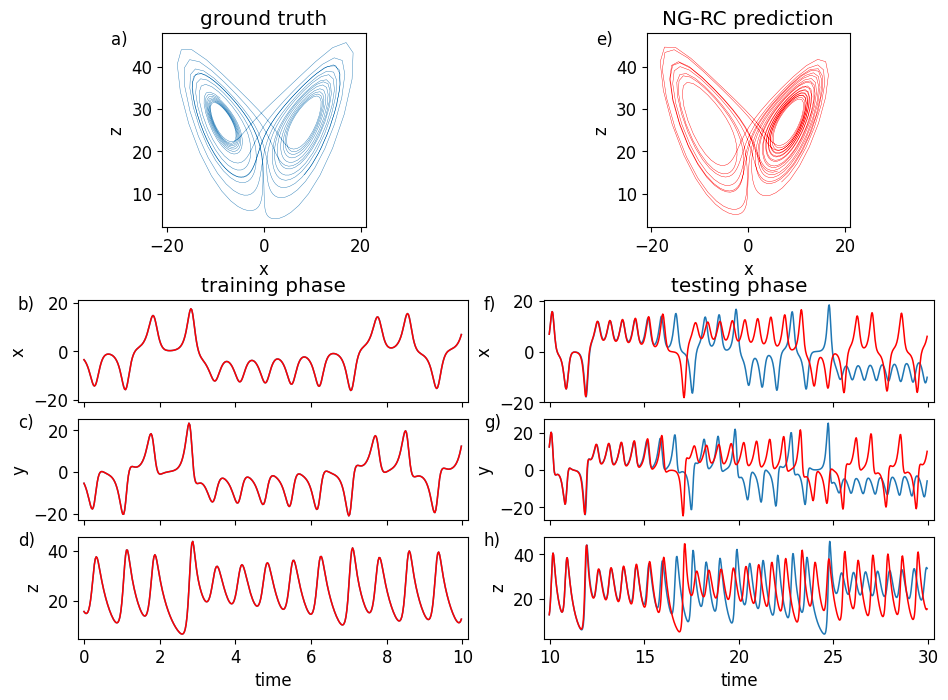

In [19]:
# -*- coding: utf-8 -*-
"""
Created on Sat Feb 20 13:17:10 2021

NVAR with time delays for Lorenz forecasting.  Don't be efficient for now.

@author: Dan
"""

##
## Parameters
##

# time step
dt=0.025
# units of time to warm up NVAR. need to have warmup_pts >= 1
warmup = 5.
# units of time to train for
traintime = 10.
# units of time to test for
testtime=20.
# total time to run for
maxtime = warmup+traintime+testtime
# how much of testtime to plot
plottime=20.
# Lyapunov time of the Lorenz system
lyaptime=1.104

# discrete-time versions of the times defined above
warmup_pts=round(warmup/dt)
traintime_pts=round(traintime/dt)
warmtrain_pts=warmup_pts+traintime_pts
testtime_pts=round(testtime/dt)
maxtime_pts=round(maxtime/dt)
plottime_pts=round(plottime/dt)
lyaptime_pts=round(lyaptime/dt)

# input dimension
d = 3
# number of time delay taps
k = 2
# size of linear part of feature vector
dlin = k*d
# size of nonlinear part of feature vector
dnonlin = int(dlin*(dlin+1)/2)
# total size of feature vector: constant + linear + nonlinear
dtot = 1 + dlin + dnonlin

# ridge parameter for regression
ridge_param = 2.5e-6

# t values for whole evaluation time
# (need maxtime_pts + 1 to ensure a step of dt)
t_eval=np.linspace(0,maxtime,maxtime_pts+1)


##
## NVAR
##
# create an array to hold the linear part of the feature vector
x = np.zeros((dlin,maxtime_pts))

# fill in the linear part of the feature vector for all times
for delay in range(k):
    for j in range(delay,maxtime_pts):
        x[d*delay:d*(delay+1),j]=lorenz_soln.y[:,j-delay]

# create an array to hold the full feature vector for training time
# (use ones so the constant term is already 1)
out_train = np.ones((dtot,traintime_pts))

# copy over the linear part (shift over by one to account for constant)
out_train[1:dlin+1,:]=x[:,warmup_pts-1:warmtrain_pts-1]

# fill in the non-linear part
cnt=0
for row in range(dlin):
    for column in range(row,dlin):
        # shift by one for constant
        out_train[dlin+1+cnt]=x[row,warmup_pts-1:warmtrain_pts-1]*x[column,warmup_pts-1:warmtrain_pts-1]
        cnt += 1


# ridge regression: train W_out to map out_train to Lorenz[t] - Lorenz[t - 1]
W_out = (x[0:d,warmup_pts:warmtrain_pts]-x[0:d,warmup_pts-1:warmtrain_pts-1]) @ out_train[:,:].T @ np.linalg.pinv(out_train[:,:] @ out_train[:,:].T + ridge_param*np.identity(dtot))

# apply W_out to the training feature vector to get the training output
x_predict = x[0:d,warmup_pts-1:warmtrain_pts-1] + W_out @ out_train[:,0:traintime_pts]

# calculate NRMSE between true Lorenz and training output
rms = np.sqrt(np.mean((x[0:d,warmup_pts:warmtrain_pts]-x_predict[:,:])**2)/total_var)
print('training nrmse: '+str(rms))

# create a place to store feature vectors for prediction
out_test = np.zeros(dtot)              # full feature vector
x_test = np.zeros((dlin,testtime_pts)) # linear part

# copy over initial linear feature vector
x_test[:,0] = x[:,warmtrain_pts-1]

# do prediction
for j in range(testtime_pts-1):
    # copy linear part into whole feature vector
    out_test[1:dlin+1]=x_test[:,j] # shift by one for constant
    # fill in the non-linear part
    cnt=0
    for row in range(dlin):
        for column in range(row,dlin):
            # shift by one for constant
            out_test[dlin+1+cnt]=x_test[row,j]*x_test[column,j]
            cnt += 1
    # fill in the delay taps of the next state
    x_test[d:dlin,j+1]=x_test[0:(dlin-d),j]
    # do a prediction
    x_test[0:d,j+1] = x_test[0:d,j]+W_out @ out_test[:]

# calculate NRMSE between true Lorenz and prediction for one Lyapunov time
test_nrmse = np.sqrt(np.mean((x[0:d,warmtrain_pts-1:warmtrain_pts+lyaptime_pts-1]-x_test[0:d,0:lyaptime_pts])**2)/total_var)
print('test nrmse: '+str(test_nrmse))

##
## Plot
##

t_linewidth=1.1
a_linewidth=0.3
plt.rcParams.update({'font.size': 12})

fig1 = plt.figure()
fig1.set_figheight(8)
fig1.set_figwidth(12)

xlabel=[10,15,20,25,30]
h=120
w=100

# top left of grid is 0,0
axs1 = plt.subplot2grid(shape=(h,w), loc=(0, 9), colspan=22, rowspan=38)
axs2 = plt.subplot2grid(shape=(h,w), loc=(52, 0), colspan=42, rowspan=20)
axs3 = plt.subplot2grid(shape=(h,w), loc=(75, 0), colspan=42, rowspan=20)
axs4 = plt.subplot2grid(shape=(h,w), loc=(98, 0), colspan=42, rowspan=20)
axs5 = plt.subplot2grid(shape=(h,w), loc=(0, 61), colspan=22, rowspan=38)
axs6 = plt.subplot2grid(shape=(h,w), loc=(52, 50),colspan=42, rowspan=20)
axs7 = plt.subplot2grid(shape=(h,w), loc=(75, 50), colspan=42, rowspan=20)
axs8 = plt.subplot2grid(shape=(h,w), loc=(98, 50), colspan=42, rowspan=20)

# true Lorenz attractor
axs1.plot(x[0,warmtrain_pts:maxtime_pts],x[2,warmtrain_pts:maxtime_pts],linewidth=a_linewidth)
axs1.set_xlabel('x')
axs1.set_ylabel('z')
axs1.set_title('ground truth')
axs1.text(-.25,.92,'a)', ha='left', va='bottom',transform=axs1.transAxes)
axs1.axes.set_xbound(-21,21)
axs1.axes.set_ybound(2,48)

# training phase x
axs2.set_title('training phase')
axs2.plot(t_eval[warmup_pts:warmtrain_pts]-warmup,x[0,warmup_pts:warmtrain_pts],linewidth=t_linewidth)
axs2.plot(t_eval[warmup_pts:warmtrain_pts]-warmup,x_predict[0,:],linewidth=t_linewidth, color='r')
axs2.set_ylabel('x')
axs2.text(-.155,0.87,'b)', ha='left', va='bottom',transform=axs2.transAxes)
axs2.axes.xaxis.set_ticklabels([])
axs2.axes.set_ybound(-21.,21.)
axs2.axes.set_xbound(-.15,10.15)

# training phase y
axs3.plot(t_eval[warmup_pts:warmtrain_pts]-warmup,x[1,warmup_pts:warmtrain_pts],linewidth=t_linewidth)
axs3.plot(t_eval[warmup_pts:warmtrain_pts]-warmup,x_predict[1,:],linewidth=t_linewidth,color='r')
axs3.set_ylabel('y')
axs3.text(-.155,0.87,'c)', ha='left', va='bottom',transform=axs3.transAxes)
axs3.axes.xaxis.set_ticklabels([])
axs3.axes.set_xbound(-.15,10.15)

# training phase z
axs4.plot(t_eval[warmup_pts:warmtrain_pts]-warmup,x[2,warmup_pts:warmtrain_pts],linewidth=t_linewidth)
axs4.plot(t_eval[warmup_pts:warmtrain_pts]-warmup,x_predict[2,:],linewidth=t_linewidth,color='r')
axs4.set_ylabel('z')
axs4.text(-.155,0.87,'d)', ha='left', va='bottom',transform=axs4.transAxes)
axs4.set_xlabel('time')
axs4.axes.set_xbound(-.15,10.15)

# prediction attractor
axs5.plot(x_test[0,:],x_test[2,:],linewidth=a_linewidth,color='r')
axs5.set_xlabel('x')
axs5.set_ylabel('z')
axs5.set_title('NG-RC prediction')
axs5.text(-.25,0.92,'e)', ha='left', va='bottom',transform=axs5.transAxes)
axs5.axes.set_xbound(-21,21)
axs5.axes.set_ybound(2,48)

# testing phase x
axs6.set_title('testing phase')
axs6.set_xticks(xlabel)
axs6.plot(t_eval[warmtrain_pts-1:warmtrain_pts+plottime_pts-1]-warmup,x[0,warmtrain_pts-1:warmtrain_pts+plottime_pts-1],linewidth=t_linewidth)
axs6.plot(t_eval[warmtrain_pts-1:warmtrain_pts+plottime_pts-1]-warmup,x_test[0,0:plottime_pts],linewidth=t_linewidth,color='r')
axs6.set_ylabel('x')
axs6.text(-.155,0.87,'f)', ha='left', va='bottom',transform=axs6.transAxes)
axs6.axes.xaxis.set_ticklabels([])
axs6.axes.set_xbound(9.7,30.3)

# testing phase y
axs7.set_xticks(xlabel)
axs7.plot(t_eval[warmtrain_pts-1:warmtrain_pts+plottime_pts-1]-warmup,x[1,warmtrain_pts-1:warmtrain_pts+plottime_pts-1],linewidth=t_linewidth)
axs7.plot(t_eval[warmtrain_pts-1:warmtrain_pts+plottime_pts-1]-warmup,x_test[1,0:plottime_pts],linewidth=t_linewidth,color='r')
axs7.set_ylabel('y')
axs7.text(-.155,0.87,'g)', ha='left', va='bottom',transform=axs7.transAxes)
axs7.axes.xaxis.set_ticklabels([])
axs7.axes.set_xbound(9.7,30.3)

# testing phase z
axs8.set_xticks(xlabel)
axs8.plot(t_eval[warmtrain_pts-1:warmtrain_pts+plottime_pts-1]-warmup,x[2,warmtrain_pts-1:warmtrain_pts+plottime_pts-1],linewidth=t_linewidth)
axs8.plot(t_eval[warmtrain_pts-1:warmtrain_pts+plottime_pts-1]-warmup,x_test[2,0:plottime_pts],linewidth=t_linewidth,color='r')
axs8.set_ylabel('z')
axs8.text(-.155,0.87,'h)', ha='left', va='bottom',transform=axs8.transAxes)
axs8.set_xlabel('time')
axs8.axes.set_xbound(9.7,30.3)

plt.savefig('predict-lorenz.png')
plt.savefig('predict-lorenz.svg')
plt.savefig('predict-lorenz.eps')
plt.savefig('predict-lorenz.pdf')